## Setup
### Import packages

In [1]:
import pcraster as pcr
import gdal, gdalconst
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt 
import pandas as pd
from shapely import wkt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Set data directory

In [2]:
os.getcwd()
dataDir = os.path.join(r'/scratch/gpfs/tianboz/GlobalDams/Data')

'/scratch/gpfs/tianboz/GlobalDams/Analysis/codePython'

### Load raw & interpolated GDAT data 

In [3]:
os.chdir(dataDir)

# Read raw GDAT data
gdat = gpd.read_file("GDAT/GlobalDam_v0_abbVarName.shp")

In [4]:
gdat['GDAT_Coord'] = gdat['geometry']

In [5]:
# Read interpolated GDAT data
result_af = gpd.read_file("Interpolate_GDAT_HydroRivers/Intp_GDAT_HydroRivers_Africa.shp")
result_na = gpd.read_file("Interpolate_GDAT_HydroRivers/Intp_GDAT_HydroRivers_NorthAmerica.shp")
result_sa = gpd.read_file("Interpolate_GDAT_HydroRivers/Intp_GDAT_HydroRivers_SouthAmerica.shp")
result_as_eu_au = gpd.read_file("Interpolate_GDAT_HydroRivers/Intp_GDAT_HydroRivers_AsiaOceaniaEurope.shp")

df_list = [result_af, result_na, result_sa, result_as_eu_au]
df_list = [df.rename(columns = {'geometry': 'Intp_Coord'}).set_geometry('Intp_Coord') for df in df_list]

# Merge with original GDAT data to get coordinates
df_list = [df.merge(gdat[['Feature_ID','GDAT_Coord']], on='Feature_ID', indicator = True) for df in df_list]

# Decision: If interpolated distance > 0.5 degrees, replace with original coordinates
for i in range(0,len(df_list)):
    df_list[i]['Correct_Coord'] = df_list[i]['Intp_Coord']
    df_list[i]['Correct_Coord'] = np.where(df_list[i]['intp_dist'] > 0.5, df_list[i]['GDAT_Coord'], df_list[i]['Correct_Coord'])
    df_list[i] = df_list[i].set_geometry('Correct_Coord')
    df_list[i]['GDAT_Coord'] = df_list[i]['GDAT_Coord'].apply(lambda x: wkt.dumps(x))
    df_list[i]['Intp_Coord'] = df_list[i]['Intp_Coord'].apply(lambda x: wkt.dumps(x))
    
# Check merge results
for i in range(0,len(df_list)):
    pd.crosstab(df_list[i]['_merge'], columns='count')

col_0,count
_merge,
both,5796


col_0,count
_merge,
both,8008


col_0,count
_merge,
both,5729


col_0,count
_merge,
both,12159


In [6]:
# Drop _merge column 
for i in range(0,len(df_list)):
    # df_list[i] = df_list[i].drop(['_merge', 'GDAT_Coord', 'Intp_Coord'], axis = 1)
    df_list[i] = df_list[i].drop(['_merge'], axis = 1)
    
# Update data
result_af = df_list[0]
result_na = df_list[1]
result_sa = df_list[2]
result_as_eu_au = df_list[3]

In [7]:
# Save data
result_af.to_file("CorrectCoord_GDAT_HydroRivers/CorrectCoord_GDAT_HydroRivers_Africa.shp")
result_na.to_file("CorrectCoord_GDAT_HydroRivers/CorrectCoord_GDAT_HydroRivers_NorthAmerica.shp")
result_sa.to_file("CorrectCoord_GDAT_HydroRivers/CorrectCoord_GDAT_HydroRivers_SouthAmerica.shp")
result_as_eu_au.to_file("CorrectCoord_GDAT_HydroRivers/CorrectCoord_GDAT_HydroRivers_AsiaOceaniaEurope.shp")

# Combine continent-specific GDAT shapefiles
os.chdir(os.path.join(dataDir, "CorrectCoord_GDAT_HydroRivers"))
result_world = result_af.append(result_na).append(result_sa).append(result_as_eu_au)
result_world.to_file("CorrectCoord_GDAT_HydroRivers_World.shp")

<AxesSubplot:>

Text(0.5, 1.0, 'Corrected GDAT Data – Africa')

<AxesSubplot:>

Text(0.5, 1.0, 'Corrected GDAT Data – North America')

<AxesSubplot:>

Text(0.5, 1.0, 'Corrected GDAT Data – South America')

<AxesSubplot:>

Text(0.5, 1.0, 'Corrected GDAT Data – Asia, Oceania & Europe')

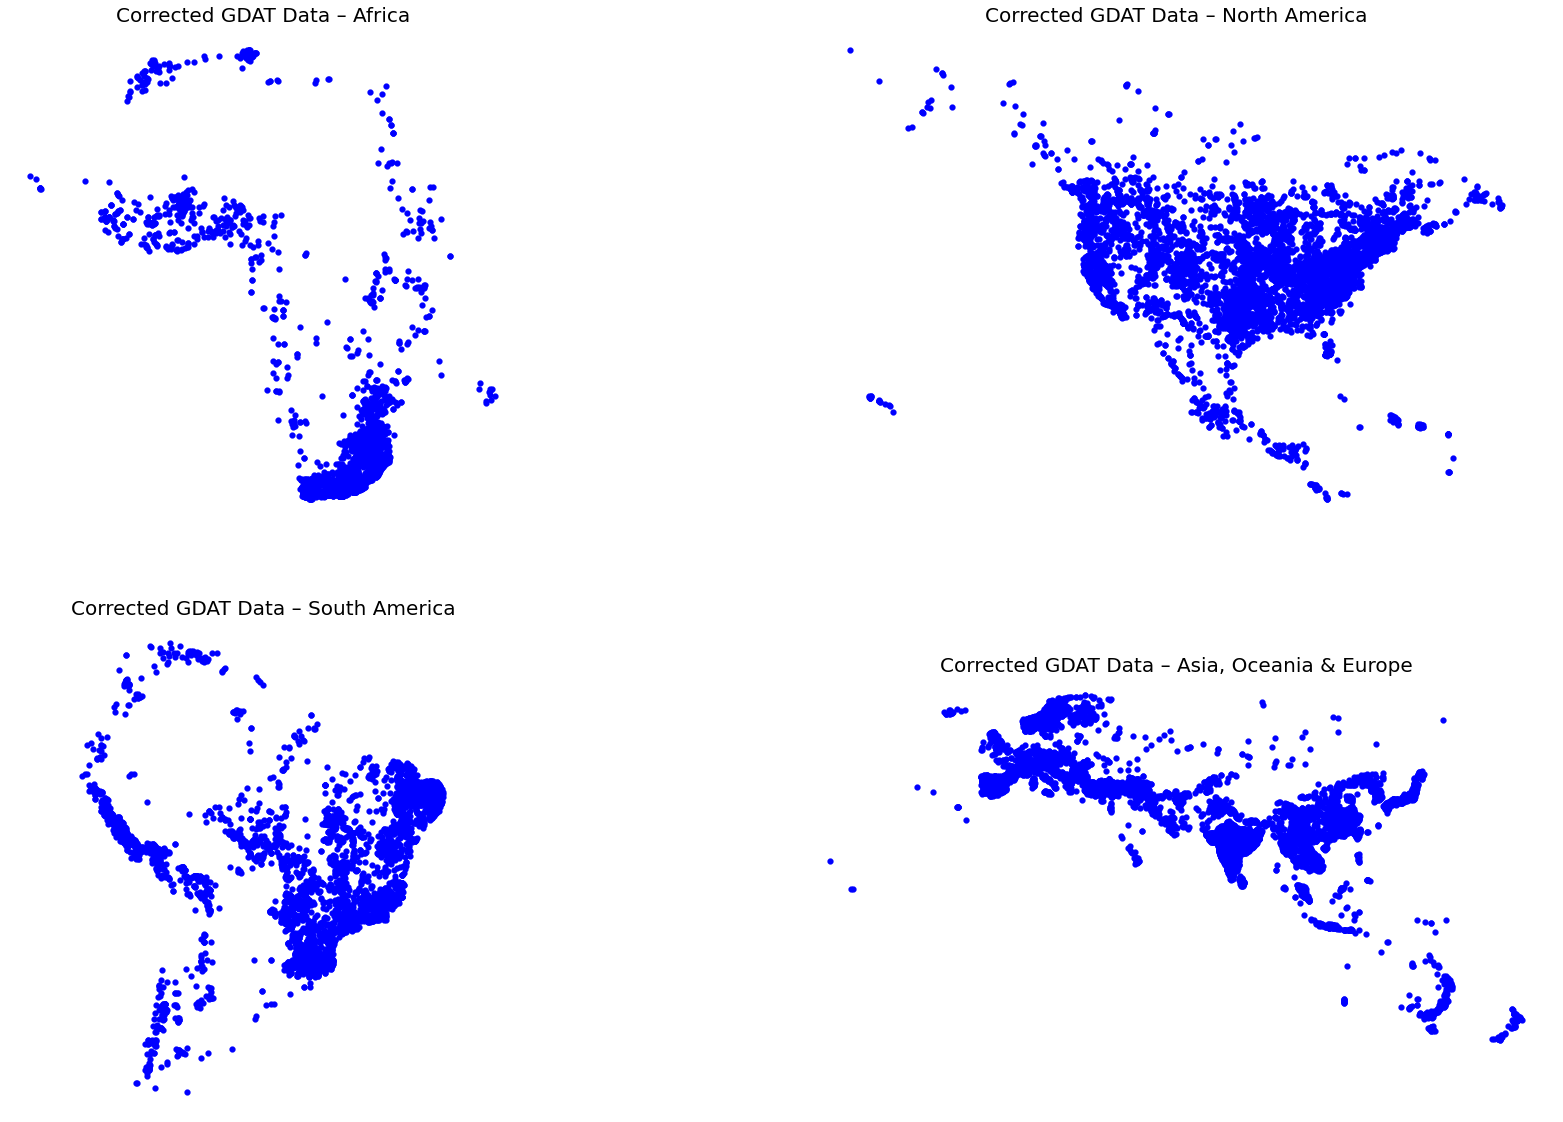

In [8]:
# Plotting data 
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(30, 20))
result_af.plot(ax=ax1, color="blue", linewidth = 0.2)
ax1.set_title("Corrected GDAT Data – Africa", fontsize=20)
ax1.set_axis_off()

result_na.plot(ax=ax2, color="blue", linewidth = 0.2)
ax2.set_title("Corrected GDAT Data – North America", fontsize=20)
ax2.set_axis_off()

result_sa.plot(ax=ax3, color="blue", linewidth = 0.2)
ax3.set_title("Corrected GDAT Data – South America", fontsize=20)
ax3.set_axis_off()

result_as_eu_au.plot(ax=ax4, color="blue", linewidth = 0.2)
ax4.set_title("Corrected GDAT Data – Asia, Oceania & Europe", fontsize=20)
ax4.set_axis_off()

plt.show()